In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

device = "cuda:1" if torch.cuda.is_available() else "cpu"

In [2]:
def imshow(tensor, model='', renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).write_image('images/' + model + '/' + kwargs.get('title') + '.png')

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [3]:
import numpy as np
from einops import repeat

n = 1000
m = 10

gcd_targets = np.random.randint(1, 65, size=n)
gcd_targets_expanded = repeat(gcd_targets, 'n -> (n m)', m=m)
scaling_factors = np.random.randint(1, 256 // gcd_targets_expanded[:, None], size=(n * m, 3))

numbers = gcd_targets_expanded[:, None] * scaling_factors
numbers_grouped = numbers.reshape(n, m, 3)

for i, target_gcd in enumerate(gcd_targets[:2]):
    print(f"\nTarget GCD: {target_gcd}")
    print("Triplets:")
    print(numbers_grouped[i])


Target GCD: 64
Triplets:
[[128 192  64]
 [ 64  64  64]
 [192  64 192]
 [128 128 192]
 [192 128 192]
 [ 64 128 192]
 [ 64  64 192]
 [192 128 128]
 [192  64 192]
 [ 64  64  64]]

Target GCD: 16
Triplets:
[[144 224  32]
 [176 160  64]
 [ 80  64  80]
 [ 80 128 240]
 [240 144 128]
 [144 208 128]
 [144 160  96]
 [144 144  48]
 [160  64 160]
 [ 80  96  96]]


In [4]:
numbers_tensor = torch.tensor(numbers, dtype=int)
gcd_tensor = torch.tensor(gcd_targets_expanded, dtype=int).reshape(10000, 1)
numbers_tensor.shape, gcd_tensor.shape

(torch.Size([10000, 3]), torch.Size([10000, 1]))

In [5]:
concatenated_tensor = torch.cat((numbers_tensor, gcd_tensor), dim=1)
concatenated_tensor.shape

torch.Size([10000, 4])

In [6]:
sample_indices = np.random.choice(concatenated_tensor.shape[0], size=5, replace=False)
samples = concatenated_tensor[sample_indices]
samples

tensor([[189, 189, 126,  63],
        [114, 152, 152,  38],
        [150,  30, 180,  30],
        [198, 216,  90,   9],
        [182, 130,  52,  26]])

In [ ]:
training_datapoints = []
for _ in range(2000):
  sample_indices = np.random.choice(concatenated_tensor.shape[0], size=1, replace=False)
  samples = concatenated_tensor[sample_indices]
  prompt = ''
  for idx, tensor in enumerate(samples):
    prompt += ','.join(map(str, (tensor[:-1].tolist()))) + f'=>{tensor[-1]}'*10
  training_datapoints.append(prompt)

test_datapoints = []
for _ in range(1000):
  sample_indices = np.random.choice(concatenated_tensor.shape[0], size=1, replace=False)
  samples = concatenated_tensor[sample_indices]
  prompt = ''
  for idx, tensor in enumerate(samples):
    prompt += ','.join(map(str, (tensor[:-1].tolist()))) + f'=>{tensor[-1]}'*10
  test_datapoints.append(prompt)

In [8]:
print(training_datapoints[0])

60,120,180=>60


In [9]:
import requests
import pypac

def request(method, url, **kwargs):
    with pypac.PACSession() as session:
        return session.request(method=method, url=url, **kwargs)

requests.request = request

In [10]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

In [11]:
# MODEL='solu-2l'
# model = HookedTransformer.from_pretrained(MODEL, device=device)
# model.cfg.d_vocab = 16
# model

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_theme(rc={'figure.figsize':(5,5)})

In [4]:
from transformer_lens import evals
model_names = ['attn-only-1l','attn-only-2l','attn-only-3l']

Model: attn-only-1l
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Loaded pretrained model attn-only-1l into HookedTransformer
Model: attn-only-2l
Loaded pretrained model attn-only-2l into HookedTransformer
Loaded pretrained model attn-only-2l into HookedTransformer
Loaded pretrained model attn-only-2l into HookedTransformer
Loaded pretrained model attn-only-2l into HookedTransformer
Loaded pretrained model attn-only-2l into HookedTransformer
Loaded pretrained model attn-only-2l into HookedTransformer


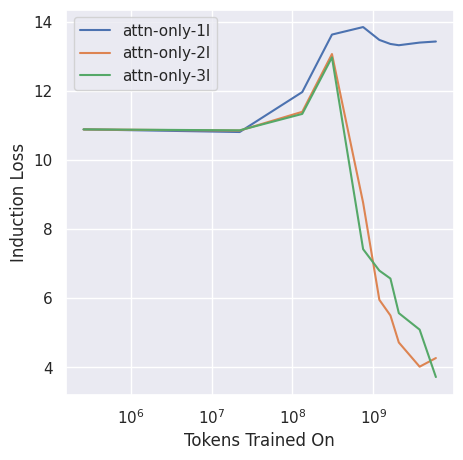

In [12]:
for model_name in model_names:
  print(f"Model: {model_name}")

  checkpoint_indices = range(0, 100, 10)
  checkpointed_models = []
  tokens_trained_on = []
  induction_losses = []

  for index in checkpoint_indices:
    model_for_this_checkpoint = HookedTransformer.from_pretrained(model_name, checkpoint_index=index, device=device)
    checkpointed_models.append(model_for_this_checkpoint)

    tokens_seen_for_this_checkpoint = model_for_this_checkpoint.cfg.checkpoint_value
    tokens_trained_on.append(tokens_seen_for_this_checkpoint)

    induction_loss_for_this_checkpoint = evals.induction_loss(model_for_this_checkpoint, device=device).item()
    induction_losses.append(induction_loss_for_this_checkpoint)

  ax = sns.lineplot(x=tokens_trained_on, y=induction_losses, markers=True, label=model_name)
  ax.set(xscale='log')
  ax.set(xlabel="Tokens Trained On", ylabel="Induction Loss")
  plt.legend()
  plt.savefig(f'images/induction_loss_{model_name}.png')